In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import matplotlib.pyplot as plt
from pocket_coffea.lib.deltaR_matching import object_matching, deltaR_matching_nonunique
import vector
import math
import numpy as np
vector.register_awkward()

In [33]:
filename = "root://xrootd-cms.infn.it//store/mc/Run3Summer22NanoAODv12/QCD_PT-15_TuneCP5_Flat2018_13p6TeV_pythia8/NANOAODSIM/JMENano12p5_132X_mcRun3_2022_realistic_v3-v2/70000/1a3d12b4-15b7-415c-a25a-df0e81f71648.root"
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=2000000).events()
print("Events read:", len(events))

Events read: 84101


In [34]:
neutrinos=events.GenPart[(abs(events.GenPart.pdgId)==12) | (abs(events.GenPart.pdgId)==14) |(abs(events.GenPart.pdgId)==16)]
gen_jet=events.GenJet
print(neutrinos.phi, neutrinos.eta, neutrinos.pt)
print(gen_jet.px[-3])

[[], [], [], [], [], [], [], [1.62], ... -1.72], [1.09], [], [], [], [], [2.32]] [[], [], [], [], [], [], [], [-0.181, ... -2.72], [-0.143], [], [], [], [], [-0.213]] [[], [], [], [], [], [], [], [1.63], ... 5.86, 1.26], [86.5], [], [], [], [], [9.09]]
[298, 126, -408, -18.3, -2.79, -10.9, 10.8]


In [35]:
neutrinos_matched = deltaR_matching_nonunique(
                    gen_jet, neutrinos, 0.4 # 0.4
                )

In [36]:
print(neutrinos_matched[-3].phi, neutrinos_matched[-3].eta)
print(gen_jet[-3].phi, gen_jet[-3].eta)

[[], [], [], [], [], [], []] [[], [], [], [], [], [], []]
[1.52, -1.55, -2.42, -2.22, -1.8, -2.84, 0.113] [0.0827, -0.0371, -0.245, 0.217, 0.814, 0.389, -1.78]


In [37]:
print(gen_jet.metric_table(neutrinos)[-3][2])
print(gen_jet.metric_table(neutrinos)[-3])
print(gen_jet[-3][2].hadronFlavour)
neutrino_mother=events.GenPart[neutrinos.genPartIdxMother].pdgId
print(neutrino_mother[-3])
for num, gen_part in enumerate(events.GenPart[-3]):
    print(num, gen_part.pdgId, gen_part.genPartIdxMother)

[]
[[], [], [], [], [], [], []]
0
[]
0 -3 -1
1 1 -1
2 -3 0
3 1 0
4 3 2
5 21 2
6 21 2
7 21 2
8 21 2
9 -3 2
10 2 -1
11 21 -1
12 -2 -1
13 1 3
14 21 3
15 21 3
16 21 3
17 21 3
18 21 3
19 21 3
20 21 3
21 21 3
22 -1 3
23 331 3
24 111 3
25 221 3
26 111 3
27 111 3
28 111 3
29 221 3
30 1 3
31 21 3
32 21 2
33 21 2
34 21 2
35 21 2
36 21 2
37 21 2
38 21 2
39 21 2
40 21 2
41 21 2
42 -3 2
43 111 2
44 111 2
45 111 4
46 111 3
47 111 3
48 22 23
49 22 24
50 22 24
51 111 3
52 22 25
53 22 26
54 22 26
55 22 27
56 22 27
57 22 28
58 22 29
59 22 29
60 22 43
61 22 44
62 22 45
63 22 45
64 11 10
65 -11 10
66 22 46
67 22 46
68 22 47
69 22 51


sum the quadrivector of the neutrinos

In [38]:
print(ak.sum(neutrinos.px, axis=-1))
print(neutrinos[7].px)
print(neutrinos[-3].px)
# print(ak.sum(neutrinos, axis=-2))
# print(neutrinos[:,0]+neutrinos[:,1])

[0, 0, 0, 0, 0, 0, 0, -0.0757, 0, 0, 0, ... 0, 0, 0, 0, -0.595, 40, 0, 0, 0, 0, -6.2]
[-0.0757]
[]


In [39]:
neutrinos_px = ak.sum(neutrinos_matched.px, axis=-1)
neutrinos_py = ak.sum(neutrinos_matched.py, axis=-1)
neutrinos_pz = ak.sum(neutrinos_matched.pz, axis=-1)
neutrinos_e = ak.sum(neutrinos_matched.energy, axis=-1)
print(neutrinos_px, len(neutrinos_px), len(neutrinos_px[0]), len(neutrinos_px[1]))

# COMPUTE PT, ETA, PHI, MASS
neutrinos_pt = np.sqrt(neutrinos_px**2 + neutrinos_py**2)
print(neutrinos_pt, len(neutrinos_pt), len(neutrinos_pt[0]), len(neutrinos_pt[1]))
# neutrinos_eta = np.arcsinh(neutrinos_pz/neutrinos_pt)
neutrinos_eta = np.arctanh(neutrinos_pz/np.sqrt(neutrinos_pt**2 + neutrinos_pz**2))
neutrinos_phi = np.arctan2(neutrinos_py, neutrinos_px)
neutrinos_mass = np.sqrt(neutrinos_e**2 - neutrinos_px**2 - neutrinos_py**2 - neutrinos_pz**2)

neutrinos_pt=ak.nan_to_num(neutrinos_pt, nan=0)
neutrinos_eta=ak.nan_to_num(neutrinos_eta, nan=0)
neutrinos_phi=ak.nan_to_num(neutrinos_phi, nan=0)
neutrinos_mass=ak.nan_to_num(neutrinos_mass, nan=0)

print(len(neutrinos_px), len(neutrinos_px[0]))
print(neutrinos_e[-3])
print(neutrinos_e[-3])

neutrino_sum = ak.zip(
    {"px": neutrinos_px, "py": neutrinos_py, "pz": neutrinos_pz, "E": neutrinos_e},
    with_name="Momentum4D",
)
neutrino_sum_4vec=ak.zip(
    {"pt": neutrinos_pt, "eta": neutrinos_eta, "phi": neutrinos_phi, "mass": neutrinos_mass},
    with_name="PtEtaPhiMLorentzVector",
)
print("\nneutrino_sum")
print(neutrino_sum[-3].mass)
print(neutrino_sum[-3].E)
print(neutrino_sum[-3].pt)
print(neutrino_sum[-3].phi)
print(neutrino_sum[-3].eta)
print(neutrino_sum[-3].px)
print(neutrino_sum[-3][2])

print("\nneutrino_sum_4vec")
print(neutrino_sum_4vec[-3].mass)
print(neutrino_sum_4vec[-3].E)
print(neutrino_sum_4vec[-3].pt)
print(neutrino_sum_4vec[-3].phi)
print(neutrino_sum_4vec[-3].eta)
print(neutrino_sum_4vec[-3].px)
print(neutrino_sum_4vec[-3][2])

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, ... 0, 0, -6.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] 84101 6 7
[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, ... 0, 0, 9.09, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] 84101 6 7
84101 6
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]

neutrino_sum
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
{px: 0, py: 0, pz: 0, E: 0}

neutrino_sum_4vec
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
{pt: 0, eta: 0, phi: 0, mass: 0}


/work/mmalucch/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/work/mmalucch/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [40]:
print(neutrino_sum[-3], len(neutrino_sum[-3]), ak.count(neutrino_sum))
print(neutrinos_matched[-3], len(neutrinos_matched[-3]), ak.count(neutrinos_matched))
print(gen_jet[-3], len(gen_jet), ak.count(gen_jet))

[{px: 0, py: 0, pz: 0, E: 0}, {px: 0, py: 0, pz: 0, ... {px: 0, py: 0, pz: 0, E: 0}] 7 2943188
[[], [], [], [], [], [], []] 7 184137
[{nConstituents: 41, eta: 0.0827, mass: 161, ... hadronFlavour: 0, partonFlavour: 2}] 84101 5150579


sum four vectors of the neutrinos and the gen jet matched to them

In [41]:
gen_jet_neutrino_px =gen_jet.px + neutrino_sum.px
gen_jet_neutrino_py =gen_jet.py + neutrino_sum.py
gen_jet_neutrino_pz =gen_jet.pz + neutrino_sum.pz
gen_jet_neutrino_e =gen_jet.energy + neutrino_sum.E
gen_jet_neutrino_pt=np.sqrt(gen_jet_neutrino_px**2+gen_jet_neutrino_py**2)
print(gen_jet_neutrino_px[-3])
print(gen_jet_neutrino_py[-3])
print(gen_jet_neutrino_pt[-3])

# neutrino_sum_4vec=ak.with_name(neutrino_sum, "PtEtaPhiMCollection")
# print(neutrino_sum_4vec)
# print(neutrino_sum)


# gen_jet_neutrino = ak.zip(
#     {"px": gen_jet_neutrino_px, "py": gen_jet_neutrino_py, "pz": gen_jet_neutrino_pz, "E": gen_jet_neutrino_e},
#     with_name="Momentum4D",
# )
gen_jet_neutrino = ak.with_field(gen_jet, gen_jet_neutrino_px, "px")
gen_jet_neutrino = ak.with_field(gen_jet_neutrino, gen_jet_neutrino_py, "py")
gen_jet_neutrino = ak.with_field(gen_jet_neutrino, gen_jet_neutrino_pz, "pz")
gen_jet_neutrino = ak.with_field(gen_jet_neutrino, gen_jet_neutrino_e, "E")
gen_jet_neutrino = ak.with_field(gen_jet_neutrino, np.sqrt(gen_jet_neutrino_px**2+gen_jet_neutrino_py**2), "pt")



print("gen_jet.pt",gen_jet.pt[-3][2])
print("gen_jet.px",gen_jet.px[-3][2])
print("gen_jet.py",gen_jet.py[-3][2])
print(neutrino_sum.px[-3])
print(neutrino_sum.pt[-3])
# print(gen_jet_neutrino_px[-3], len(gen_jet_neutrino_px), ak.count(gen_jet_neutrino_px))
# print(gen_jet.px[7], gen_jet.px[7][1])
# print(neutrino_sum.px[7])
# print(gen_jet_neutrino_px[7], len(gen_jet_neutrino_px), ak.count(gen_jet_neutrino_px))
# print(gen_jet_neutrino_px[7][1])
# print(gen_jet_neutrino[-3][2], len(gen_jet_neutrino[-3]), ak.count(gen_jet_neutrino))
print("gen_jet_neutrino.pt",gen_jet_neutrino.pt[-3], gen_jet_neutrino.pt[-3][2])
print("gen_jet_neutrino.px",gen_jet_neutrino.px[-3], gen_jet_neutrino.px[-3][2])

[298, 126, -408, -18.3, -2.79, -10.9, 10.8]
[6.49e+03, -6.09e+03, -357, -24.2, -12.2, -3.36, 1.23]
[6.5e+03, 6.09e+03, 543, 30.4, 12.5, 11.4, 10.9]
gen_jet.pt 542.7500610351562
gen_jet.px -408.4928283691406
gen_jet.py -357.36712646484375
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
gen_jet_neutrino.pt [6.5e+03, 6.09e+03, 543, 30.4, 12.5, 11.4, 10.9] 542.7500610351562
gen_jet_neutrino.px [298, 126, -408, -18.3, -2.79, -10.9, 10.8] -408.4928283691406


In [42]:
print(math.sqrt(1119**2-623**2))
print(math.sqrt(974**2+657**2))
print(math.sqrt(976**2+624**2))
print(math.sqrt(804**2+6210**2))


929.5332161897175
1174.872333489899
1158.426519033469
6261.830083929139


In [43]:
gen_jet_neutrino_4vec=gen_jet+neutrino_sum_4vec
print("gen_jet[-3].pt", gen_jet[-3].pt, gen_jet[-3][2].pt)
print("gen_jet[-3].px", gen_jet[-3].px, gen_jet[-3][2].px)
print("gen_jet[-3].py", gen_jet[-3].py, gen_jet[-3][2].py)
print("neutrino_sum_4vec[-3].pt", neutrino_sum_4vec[-3].pt, neutrino_sum_4vec[-3][2].pt)
print("neutrino_sum_4vec[-3].px", neutrino_sum_4vec[-3].px, neutrino_sum_4vec[-3][2].px)
print("neutrino_sum_4vec[-3].py", neutrino_sum_4vec[-3].py, neutrino_sum_4vec[-3][2].py)
print("gen_jet_neutrino_4vec[-3].pt", gen_jet_neutrino_4vec[-3].pt, gen_jet_neutrino_4vec[-3][2].pt)
print("gen_jet_neutrino_4vec[-3].px", gen_jet_neutrino_4vec[-3].px, gen_jet_neutrino_4vec[-3][2].px)
print("gen_jet_neutrino_4vec[-3].py", gen_jet_neutrino_4vec[-3].py, gen_jet_neutrino_4vec[-3][2].py)
print(gen_jet_neutrino_4vec.metric_table(gen_jet_neutrino_4vec)[-3])


gen_jet[-3].pt [6.5e+03, 6.09e+03, 543, 30.4, 12.5, 11.4, 10.9] 542.7500610351562
gen_jet[-3].px [298, 126, -408, -18.3, -2.79, -10.9, 10.8] -408.49282158436375
gen_jet[-3].py [6.49e+03, -6.09e+03, -357, -24.2, -12.2, -3.36, 1.23] -357.36709902803165
neutrino_sum_4vec[-3].pt [0, 0, 0, 0, 0, 0, 0] 0.0
neutrino_sum_4vec[-3].px [0, 0, 0, 0, 0, 0, 0] 0.0
neutrino_sum_4vec[-3].py [0, 0, 0, 0, 0, 0, 0] 0.0
gen_jet_neutrino_4vec[-3].pt [6.5e+03, 6.09e+03, 543, 30.4, 12.5, 11.4, 10.9] 542.7500842070499
gen_jet_neutrino_4vec[-3].px [298, 126, -408, -18.3, -2.79, -10.9, 10.8] -408.4928283691406
gen_jet_neutrino_4vec[-3].py [6.49e+03, -6.09e+03, -357, -24.2, -12.2, -3.36, 1.23] -357.36712646484375
[[0, 3.08, 2.36, 2.54, 3.05, 1.94, 2.34], ... 2.34, 2.41, 2.97, 3.07, 3.22, 3.67, 0]]


In [44]:
print(gen_jet.hadronFlavour)
print(gen_jet.pt[-3], gen_jet.pt[-3][2])
print(gen_jet.px[-3], gen_jet.px[-3][2])


gen_jet_neutrino_4vec_tot=ak.with_field(gen_jet, gen_jet_neutrino_4vec.pt, "pt")
gen_jet_neutrino_4vec_tot=ak.with_field(gen_jet_neutrino_4vec_tot, gen_jet_neutrino_4vec.eta, "eta")
gen_jet_neutrino_4vec_tot=ak.with_field(gen_jet_neutrino_4vec_tot, gen_jet_neutrino_4vec.phi, "phi")
gen_jet_neutrino_4vec_tot=ak.with_field(gen_jet_neutrino_4vec_tot, gen_jet_neutrino_4vec.mass, "mass")

print(gen_jet_neutrino_4vec_tot.hadronFlavour   )
print(gen_jet_neutrino_4vec_tot.px[-3], gen_jet_neutrino_4vec_tot.px[-3][2])
print(gen_jet_neutrino_4vec_tot.py[-3], gen_jet_neutrino_4vec_tot.py[-3][2])
print(gen_jet_neutrino_4vec_tot.pt[-3], gen_jet_neutrino_4vec_tot.pt[-3][2])
print(events.Jet.pt[-3], events.Jet.pt[-3][2])

[[4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, ... 0, 0, 4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0]]
[6.5e+03, 6.09e+03, 543, 30.4, 12.5, 11.4, 10.9] 542.7500610351562
[298, 126, -408, -18.3, -2.79, -10.9, 10.8] -408.4928283691406
[[4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, ... 0, 0, 4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0]]
[298, 126, -408, -18.3, -2.79, -10.9, 10.8] -408.4928283691406
[6.49e+03, -6.09e+03, -357, -24.2, -12.2, -3.36, 1.23] -357.36712646484375
[6.5e+03, 6.09e+03, 543, 30.4, 12.5, 11.4, 10.9] 542.7500610351562
[6.63e+03, 5.88e+03, 569, 22.5, 10.8, 9.17, 2.77] 569.0


In [45]:
GenJetMatched,JetMatched,deltaR_matched=object_matching(gen_jet_neutrino_4vec_tot, events.Jet, 0.2)

In [46]:
print(GenJetMatched.pt[-3], GenJetMatched.pt[-3][2])
print(JetMatched.pt[-3], JetMatched.pt[-3][2])
print(deltaR_matched[-3], deltaR_matched[-3][2])

[6.5e+03, 6.09e+03, 543, 30.4, 10.9, 12.5, None] 542.7500610351562
[6.63e+03, 5.88e+03, 569, 22.5, 10.8, 9.17, None] 569.0
[0.0038, 0.00256, 0.00862, 0.0249, 0.0811, 0.101, None] 0.008618717081844807


In [47]:
JetMatched=ak.with_field(JetMatched,JetMatched.pt*(1-JetMatched.rawFactor)*JetMatched.PNetRegPtRawCorr, "ptPNet")
JetMatched=ak.with_field(JetMatched,JetMatched.pt*(1-JetMatched.rawFactor)*JetMatched.PNetRegPtRawCorr*JetMatched.PNetRegPtRawCorrNeutrino, "ptPNetNeutrino")

In [48]:
print(JetMatched.pt[-3], JetMatched.pt[-3][2])
print(JetMatched.ptPNet[-3], JetMatched.ptPNet[-3][2])
print(JetMatched.ptPNetNeutrino[-3], JetMatched.ptPNetNeutrino[-3][2])

[6.63e+03, 5.88e+03, 569, 22.5, 10.8, 9.17, None] 569.0
[6.62e+03, 5.93e+03, 583, 25.3, 0, 0, None] 582.7716674804688
[6.7e+03, 5.86e+03, 582, 25.5, 0, 0, None] 581.91796875


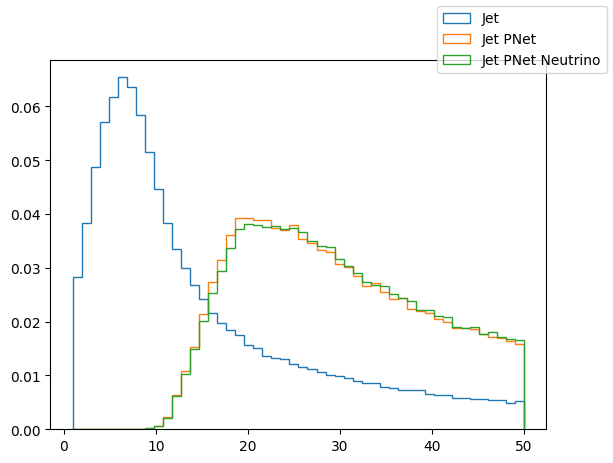

In [50]:
fig, ax = plt.subplots()
plt.hist(ak.flatten(JetMatched.pt), bins=50, range=(1, 50), histtype='step', label='Jet', density=True)
plt.hist(ak.flatten(JetMatched.ptPNet), bins=50, range=(1, 50), histtype='step', label='Jet PNet', density=True)
plt.hist(ak.flatten(JetMatched.ptPNetNeutrino), bins=50, range=(1, 50), histtype='step', label='Jet PNet Neutrino', density=True)

fig.legend()

/tmp/ipykernel_23975/1163215754.py:11: RuntimeWarning: invalid value encountered in divide
  ax2.plot(pt_reg_neutrino[1][:-1], pt_reg_neutrino[0]/pt_reg[0], 'o', label='Jet PNet Neutrino/Jet PNet')


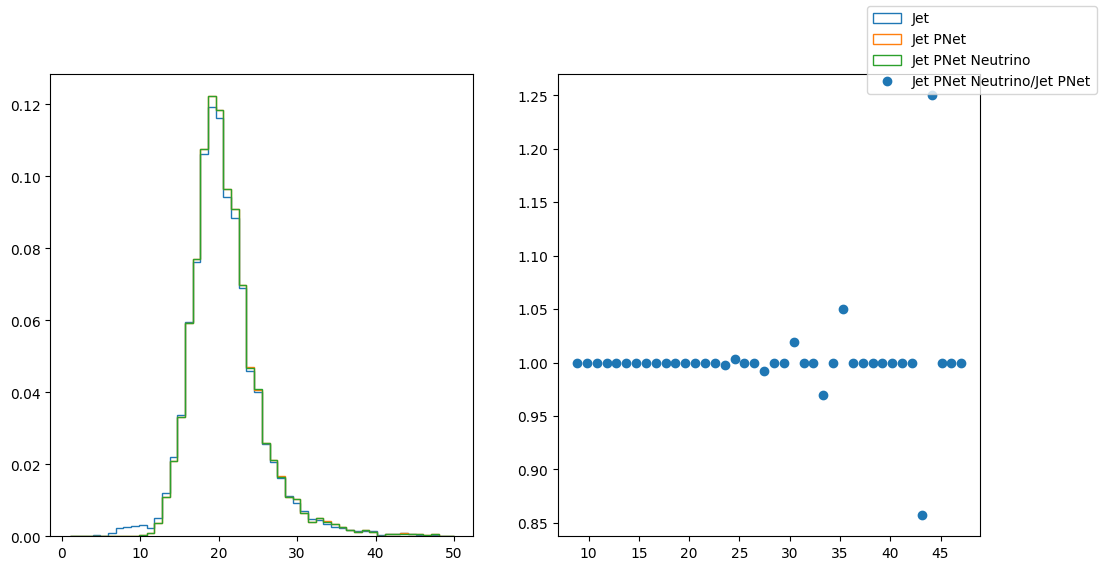

In [56]:
mask_bin=(GenJetMatched.pt>17) & (GenJetMatched.pt<20) &(GenJetMatched.eta>-3.5) & (GenJetMatched.eta<-3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(ak.flatten(JetMatched.pt[mask_bin]), bins=50, range=(1, 50), histtype='step', label='Jet', density=True)
ax1.hist(ak.flatten(JetMatched.ptPNet[mask_bin]), bins=50, range=(1, 50), histtype='step', label='Jet PNet', density=True)
ax1.hist(ak.flatten(JetMatched.ptPNetNeutrino[mask_bin]), bins=50, range=(1, 50), histtype='step', label='Jet PNet Neutrino', density=True)

pt_reg_neutrino=np.histogram(ak.to_numpy(ak.flatten(JetMatched.ptPNetNeutrino[mask_bin]), allow_missing=True),   bins=50, range=(1, 50))
pt_reg=np.histogram(ak.to_numpy(ak.flatten(JetMatched.ptPNet[mask_bin]), allow_missing=True),   bins=50, range=(1, 50))
# plot ratio
ax2.plot(pt_reg_neutrino[1][:-1], pt_reg_neutrino[0]/pt_reg[0], 'o', label='Jet PNet Neutrino/Jet PNet')
fig.legend()
